<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
import pandas as pd
import skimage
import skimage.io
from skimage.transform import rescale, resize
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from IPython.display import clear_output
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, attrs_train, attrs_test = train_test_split(data, attrs, test_size=0.1, random_state=42, shuffle = False)

In [ ]:
attrs_train.head()

Male     Asian  ... Wearing Necktie Wearing Necklace
0   1.56835  -1.88904  ...        0.694007        -0.826609
1  0.169851 -0.982408  ...         0.66676        -0.496559
2  0.997749  -1.36419  ...        0.144262        -0.841231
3   1.12272   -1.9978  ...        0.475941        -0.447025
4   1.07821   -2.0081  ...       -0.760774        -0.410152

[5 rows x 73 columns]

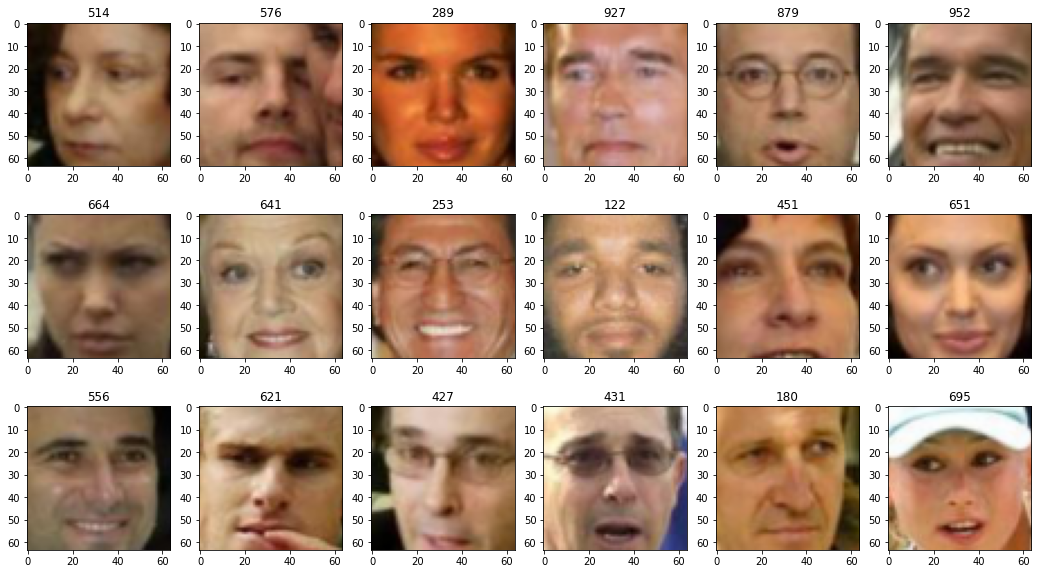

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(18, 10))
for fig_x in axes.flatten():
  random_id = int(np.random.uniform(0,1000))
  img = X_train[random_id]
  fig_x.imshow(img) 
  fig_x.set_title(random_id)

In [ ]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(X_test, batch_size=32, shuffle=False)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 64

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.flatten = nn.Flatten()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=12288, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256), # Добавление новых слоев ничего не дает :(
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=dim_code),
            # nn.ReLU()
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=12288),
            # nn.ReLU()
        )
        
    def forward(self, x):
      x = self.flatten(x).float()
      latent_code = self.encoder(x)
      reconstructed = self.decoder(latent_code)  
      return reconstructed, latent_code

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = F.mse_loss

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=0.001)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def plot_losses():
    fig = plt.figure(figsize=(10, 7))
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
    plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

    plt.ylim(0, 0.1)
    plt.xlabel('Epoch')
    plt.title('MSE loss')
    plt.legend()
    plt.show()

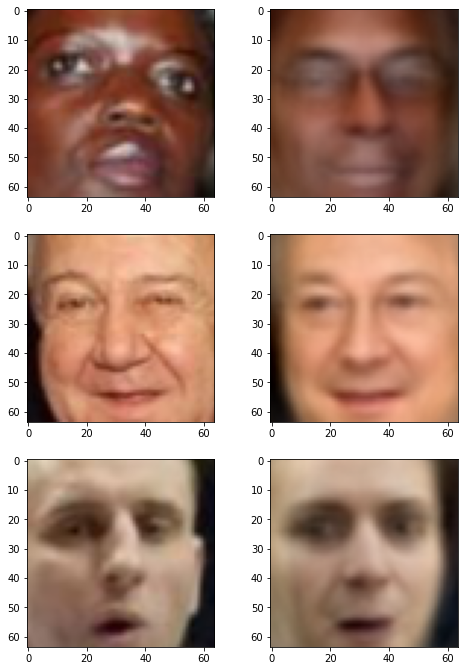

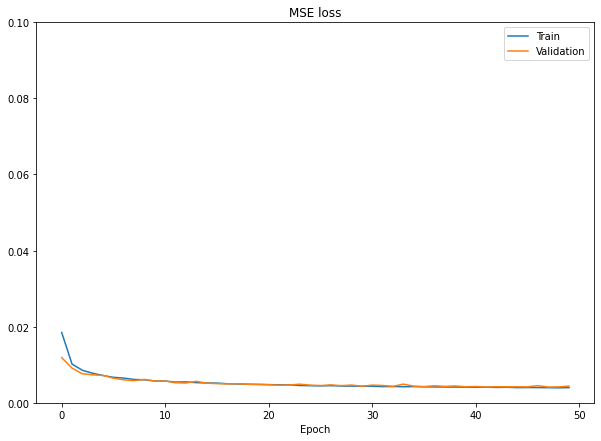

In [ ]:
n_epochs = 50

model = autoencoder
loss_fn = criterion

train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed, _ = model(X_batch.to(device))

        loss = loss_fn(reconstructed.view(-1, 64, 64, 3), X_batch.to(device).float())
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          reconstructed, _ = model(batch.to(device))
          loss = loss_fn(reconstructed.view(-1, 64, 64, 3), batch.to(device).float())
          val_losses_per_epoch.append(loss.item())

          reconstruction = reconstructed.view(-1, 64, 64, 3)
          result = reconstruction.cpu().detach().numpy()
          ground_truth = batch.numpy()

        plt.figure(figsize=(8, 20))
        clear_output(wait=True)
        for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
          plt.subplot(5, 2, 2*i+1)
          plt.imshow(np.clip(gt, 0, 1))
          plt.subplot(5, 2, 2*i+2)
          plt.imshow(np.clip(res, 0, 1))

    val_losses.append(np.mean(val_losses_per_epoch))
    plot_losses()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
model.eval()
with torch.no_grad():
    for batch in val_loader:
      reconstruction, _ = model(batch.to(device))
      reconstruction = reconstruction.view(-1, 64, 64, 3)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.numpy()
      break

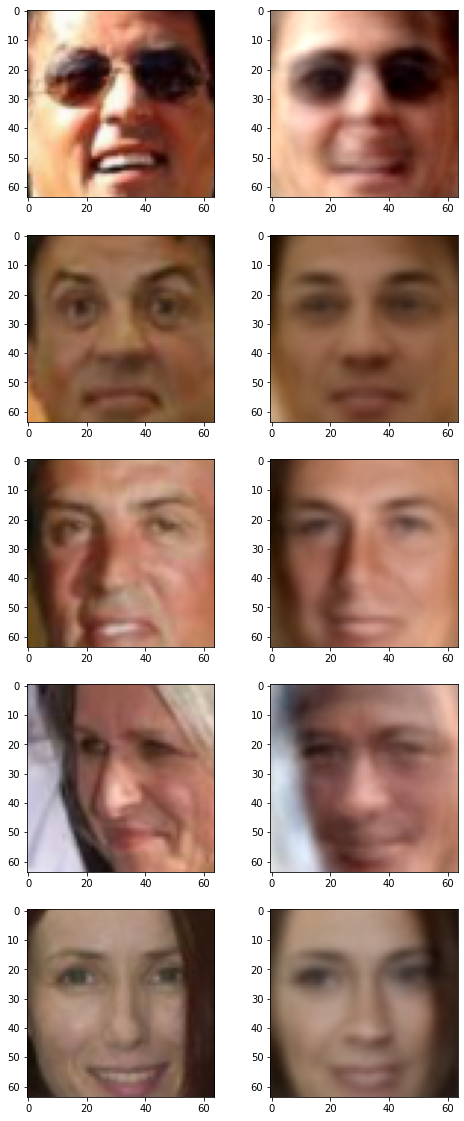

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(np.clip(gt, 0, 1))
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(np.clip(res, 0, 1))

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

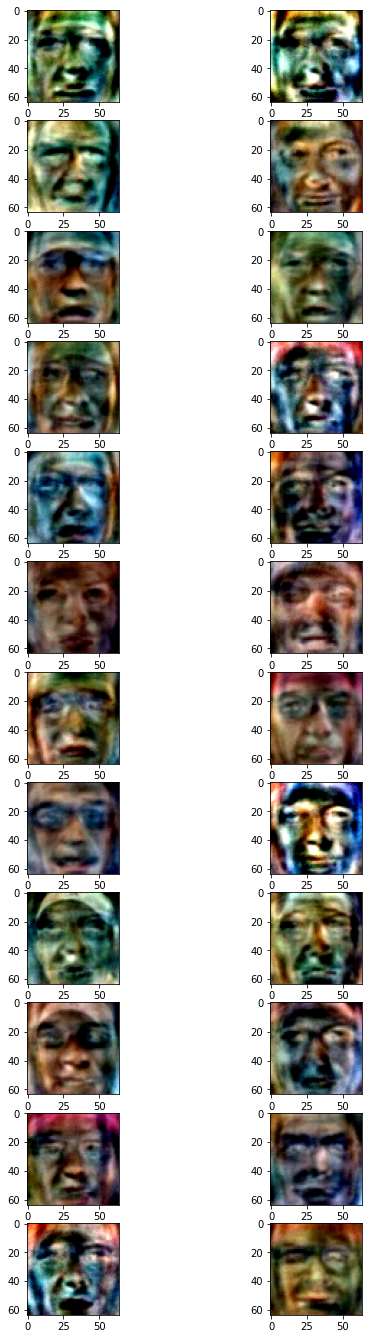

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
# z = np.random.randn(25, dim_code)
mu, sigma = 0.02323559, 0.9851335 # mean and standard deviation
z1 = np.random.normal(mu, sigma, size=(25, dim_code))
output = model.decoder(torch.FloatTensor(z1).to(device))
output = output.view(-1, 64, 64, 3)

plt.figure(figsize=(8, 24))
for i in range(output.shape[0] -1):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(np.clip(generated, 0, 1))

plt.show()

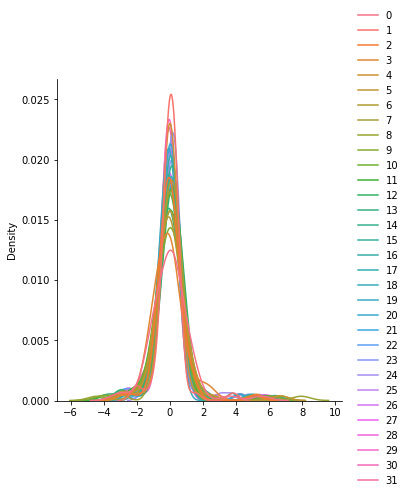

In [ ]:
import seaborn as sns

# Посмотреть распределение латентных векторов
model.eval()
with torch.no_grad():
    for batch in val_loader:
      _, latent_v = model(batch.to(device))
      break

sns.displot(latent_v.cpu().detach().numpy().T, kind="kde")

In [ ]:
lat_v = latent_v.cpu().detach().numpy()
print(lat_v.mean())
print(lat_v.std())

0.02323559
0.9851335


## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
idxs1 = attrs_train[attrs_train['Smiling'] > 2.5].sort_values(by=['Smiling'], ascending=False)['Smiling'].head(15).index
idxs2 = attrs_train[attrs_train['Smiling'] < -2.3].sort_values(by=['Smiling'], ascending=True)['Smiling'].head(15).index

t1 = torch.FloatTensor(X_train[idxs1])
t2 = torch.FloatTensor(X_train[idxs2])

model.eval()
with torch.no_grad():
  _, latent_v1 = model(t1.to(device))
  _, latent_v2 = model(t2.to(device))

latent_v1_m = latent_v1.cpu().detach().mean(dim=0)
latent_v2_m = latent_v2.cpu().detach().mean(dim=0)
latent_mean = latent_v1_m - latent_v2_m

latent_v2 = latent_v2.cpu().detach()
latent_v2_new = latent_v2 + latent_mean

output1 = model.decoder(torch.FloatTensor(latent_v2).to(device))
output1 = output1.view(-1, 64, 64, 3)

output2 = model.decoder(torch.FloatTensor(latent_v2_new).to(device))
output2 = output2.view(-1, 64, 64, 3)

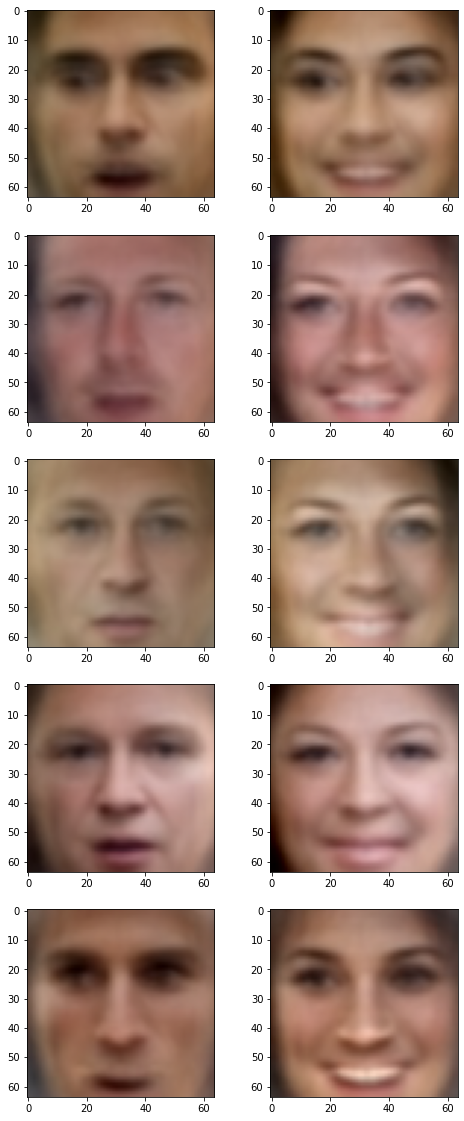

In [ ]:
plt.figure(figsize=(8, 20))
for i, (notsmile, smile) in enumerate(zip(output1[:5].cpu().detach().numpy(), output2[:5].cpu().detach().numpy())):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(np.clip(notsmile, 0, 1 ))
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(np.clip(smile, 0, 1))

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import transforms

batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
features = 10

class VAE(nn.Module):
    def __init__(self):
      super(VAE, self).__init__()

      self.flatten = nn.Flatten()
      
      self.encoder = nn.Sequential(
        nn.Linear(in_features=784, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=256), # В данном случае добавление слоев также ничего не дает
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=features*2)
  )
      
      self.decoder = nn.Sequential(
        nn.Linear(in_features=features, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=784)
  )

    def encode(self, x):

      x = self.flatten(x).float()
      x = self.encoder(x).view(-1, 2, features)
      
      mu = x[:, 0, :]
      logsigma = x[:, 1, :]

      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
      if self.training:
          std = torch.exp(0.5 * logsigma)
          eps = torch.randn_like(std)
          sample = mu + (eps * std)
          return sample
      else:
          # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
          # на инференсе выход автоэнкодера должен быть детерминирован.
          return mu
    
    def decode(self, z):

      # reparameterize
      mu, log_var = self.encode(z)
      sample = self.gaussian_sampler(mu, log_var)

      # decode
      x = self.decoder(sample)
      reconstruction = torch.sigmoid(x)

      return reconstruction

    def forward(self, x):
      mu, logsigma = self.encode(x)
      reconstruction = self.decode(x)

      return mu, logsigma, reconstruction

    def sample(self, z):
      generated = self.decoder(z)
      generated = torch.sigmoid(generated)
      generated = generated.view(-1, 1, 28, 28)
      return generated

    def get_latent(self, x):
      x = self.flatten(x).float()
      x = self.encoder(x).view(-1, 2, features)
      mu = x[:, 0, :]
      log_var = x[:, 1, :]
      z = self.gaussian_sampler(mu, log_var)
      return z

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        batch = batch[0]
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          batch = batch[0]
          mu, logsigma, reconstruction  = autoencoder(batch.to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in test_loader:
      batch = batch[0]
      mu, logsigma, reconstruction = autoencoder(batch.to(device))
      reconstruction = reconstruction.view(-1, 1, 28, 28)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.numpy()
      break

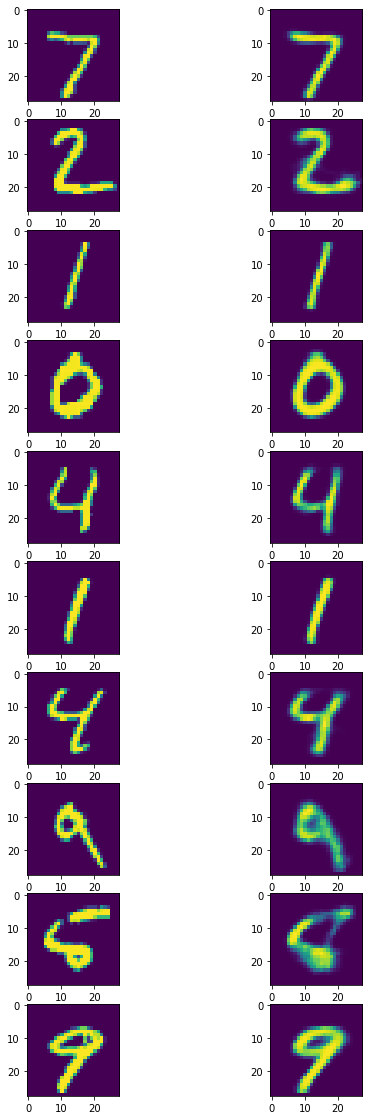

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:10], result[:10])):
  plt.subplot(10, 2, 2*i+1)
  plt.imshow(np.squeeze(gt))
  plt.subplot(10, 2, 2*i+2)
  plt.imshow(np.squeeze(res))

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(10)])
output = autoencoder.sample(torch.FloatTensor(z).to(device))
output = output.view(-1, 1, 28, 28)

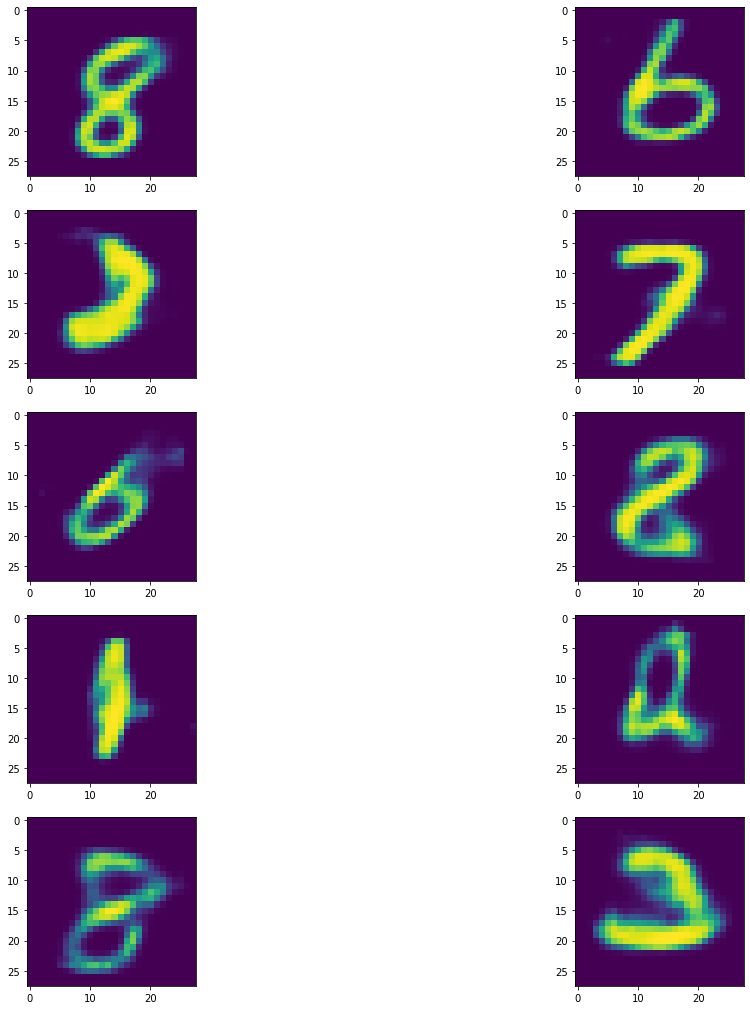

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = np.squeeze(output[i].cpu().detach().numpy())
  plt.imshow(generated)

plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
latent = None
labels = None
autoencoder.eval()
with torch.no_grad():
    for batch in test_loader:
      lab = batch[1]
      batch = batch[0]
      if (latent == None):
        latent = autoencoder.get_latent(batch.to(device))
        labels = lab
      else:
        latent = torch.cat((latent, autoencoder.get_latent(batch.to(device))), 0)
        labels = torch.cat((labels, lab), 0)

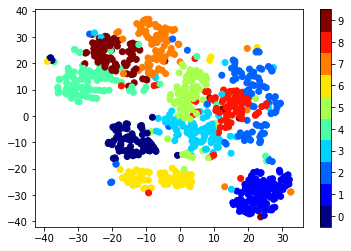

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(latent.cpu().detach().numpy()[0:832]) # 9984 Очень долго

# plot the result
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]

plt.scatter(vis_x, vis_y, c=labels[:832], cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

Что вы думаете о виде латентного представления?

Ожидал, что разделение будет более явным

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
features = 10

class CVAE(nn.Module):
    def __init__(self):
      super(CVAE, self).__init__()

      self.flatten = nn.Flatten()

      self.encoder = nn.Sequential(
        nn.Linear(in_features=794, out_features=512), # Поменять?
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=features*2)
      )

      self.decoder = nn.Sequential(
        nn.Linear(in_features=features*2, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=784) # Поменять?
      )

    def encode(self, x, class_num):

        x = self.flatten(x).float()
        x = torch.cat([x, class_num], 1)

        x = self.encoder(x).view(-1, 2, features)
      
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
          std = torch.exp(0.5 * logsigma)
          eps = torch.randn_like(std)
          sample = mu + (eps * std)
          return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):

      # reparameterize
      mu, log_var = self.encode(z, class_num)
      sample = self.gaussian_sampler(mu, log_var)

      # decode
      sample = torch.cat([sample, class_num], 1)
      x = self.decoder(sample)
      reconstruction = torch.sigmoid(x)

      return reconstruction

    def forward(self, x, class_num):
      mu, logsigma = self.encode(x, class_num)
      reconstruction = self.decode(x, class_num)

      return mu, logsigma, reconstruction

    def sample(self, z, class_num):
      z = torch.cat([z, class_num], 1)
      generated = self.decoder(z)
      generated = torch.sigmoid(generated)
      generated = generated.view(-1, 1, 28, 28)
      return generated

    def get_latent(self, x, class_num):
      x = self.flatten(x).float()

      x = torch.cat([x, class_num], 1)
      x = self.encoder(x).view(-1, 2, features)

      mu = x[:, 0, :]
      log_var = x[:, 1, :]
      z = self.gaussian_sampler(mu, log_var)
      return z

One-hot кодирование

In [ ]:
def one_hot(labels, class_size): 
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

### Обучение

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

сautoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(сautoencoder.parameters(), lr=0.0001)

In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    сautoencoder.train()
    train_losses_per_epoch = []
    for (batch, labels) in train_loader:
        batch = batch
        optimizer.zero_grad()
        mu, logsigma, reconstruction = сautoencoder(batch.to(device), one_hot(labels, 10).to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    сautoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for (batch, labels) in test_loader:
          mu, logsigma, reconstruction = сautoencoder(batch.to(device), one_hot(labels, 10).to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
z = np.array([np.random.normal(0, 1, features) for i in range(32)])
labels = torch.full((32, 10), 4)
labels = one_hot(labels, 10)
output = сautoencoder.sample(torch.FloatTensor(z).to(device), labels.to(device))
output = output.view(-1, 1, 28, 28)

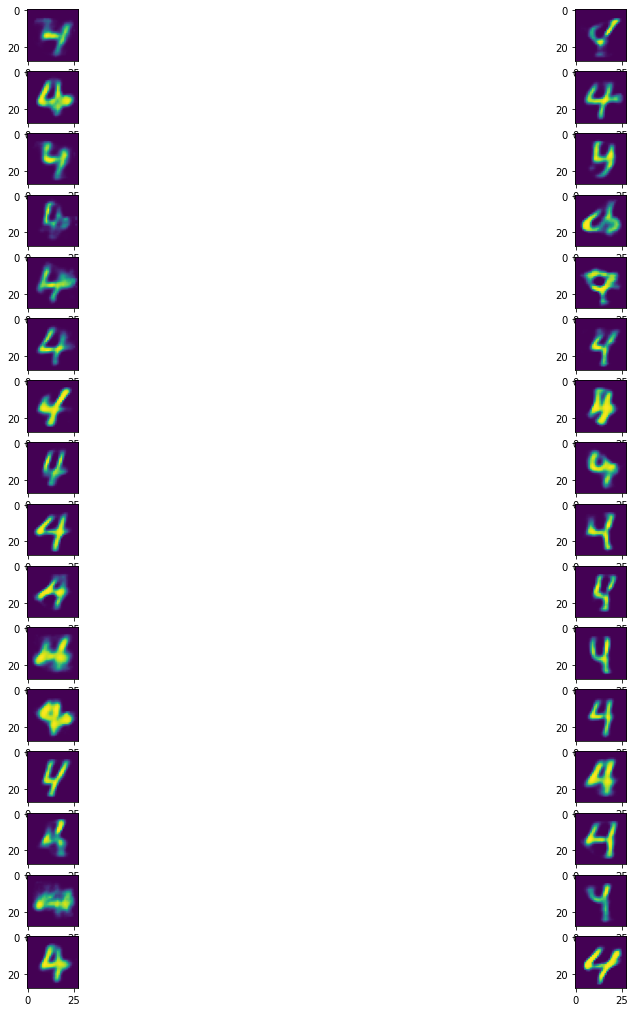

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = np.squeeze(output[i].cpu().detach().numpy())
  plt.imshow(generated)

plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
latent = None
labels = None
сautoencoder.eval()
with torch.no_grad():
    for (batch, lab) in test_loader:
      if (latent == None):
        one_h =  one_hot(lab, 10)
        latent = сautoencoder.get_latent(batch.to(device), one_h.to(device))
        labels = lab
      else:
        one_h =  one_hot(lab, 10)
        latent = torch.cat((latent, сautoencoder.get_latent(batch.to(device), one_h.to(device))), 0)
        labels = torch.cat((labels, lab), 0)

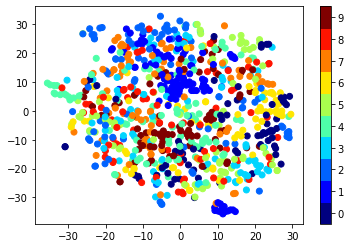

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(latent.cpu().detach().numpy()[0:832]) # 9984 Очень долго

# plot the result
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]

plt.scatter(vis_x, vis_y, c=labels[:832], cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Да, в случае CVAE нет четкого разделения

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.1
X_train_noise = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noise = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

train_ds = MyDataset(X_train, X_train_noise)
test_ds = MyDataset(X_test, X_test_noise)

In [ ]:
train_loader_dn = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=False)
val_loader_dn = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

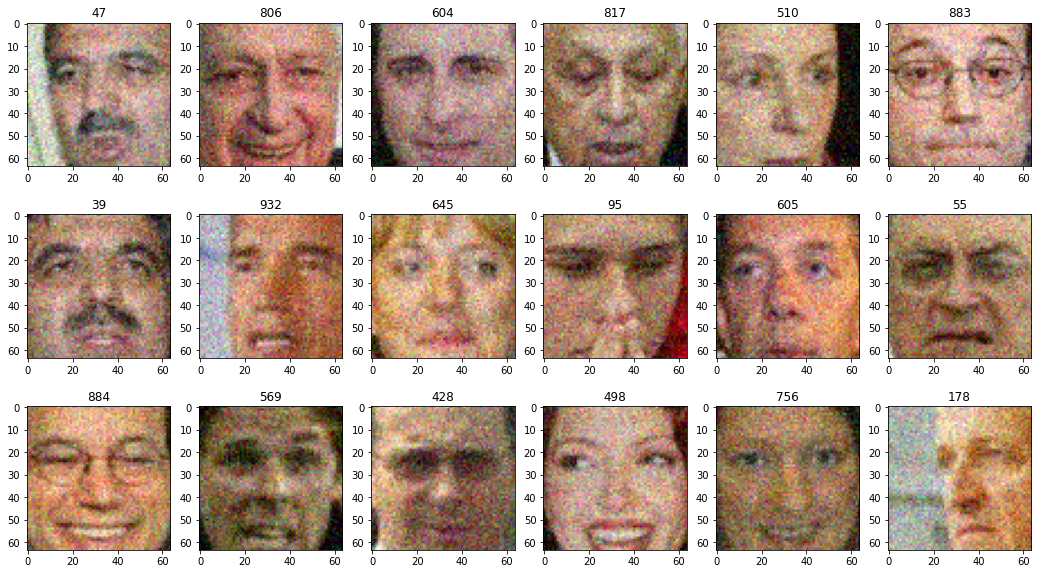

In [ ]:
# посмотреть картинки с шумом
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(18, 10))
for fig_x in axes.flatten():
  random_id = int(np.random.uniform(0,1000))
  img = X_train_noise[random_id]
  fig_x.imshow(np.clip(img, 0, 1))
  fig_x.set_title(random_id)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = F.mse_loss
ae_dn = Autoencoder().to(device)
optimizer = torch.optim.AdamW(ae_dn.parameters(), lr=0.001)

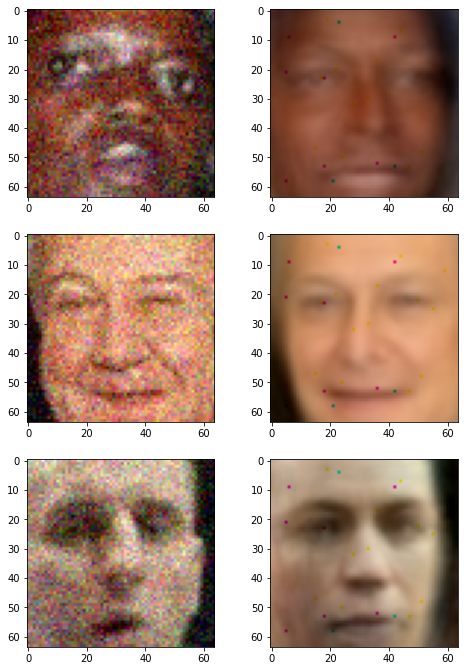

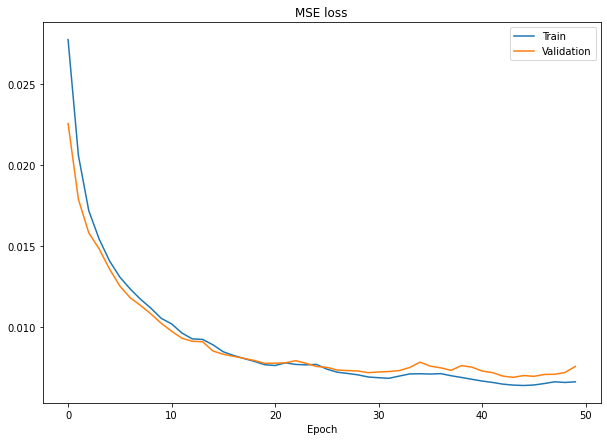

In [ ]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>
n_epochs = 50

model = ae_dn
loss_fn = criterion

train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for (X_batch, X_batch_noisy) in train_loader_dn:
        optimizer.zero_grad()
        reconstructed, _ = model(X_batch_noisy.to(device))

        loss = loss_fn(reconstructed.view(-1, 64, 64, 3), X_batch.to(device).float())
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for (batch, batch_noisy) in val_loader_dn:
          reconstructed, _ = model(batch_noisy.to(device))
          loss = loss_fn(reconstructed.view(-1, 64, 64, 3), batch.to(device).float())
          val_losses_per_epoch.append(loss.item())

          reconstruction = reconstructed.view(-1, 64, 64, 3)
          result = reconstruction.cpu().detach().numpy()
          ground_truth = batch_noisy.numpy()

        plt.figure(figsize=(8, 20))
        clear_output(wait=True)
        for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
          plt.subplot(5, 2, 2*i+1)
          plt.imshow(np.clip(gt, 0, 1))
          plt.subplot(5, 2, 2*i+2)
          plt.imshow(np.clip(res, 0, 1))

    val_losses.append(np.mean(val_losses_per_epoch))
    plot_losses()

In [ ]:
model.eval()
with torch.no_grad():
    for (batch, batch_n) in val_loader_dn:
      reconstruction, _ = model(batch_n.to(device))
      reconstruction = reconstruction.view(-1, 64, 64, 3)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch_n.numpy()
      break

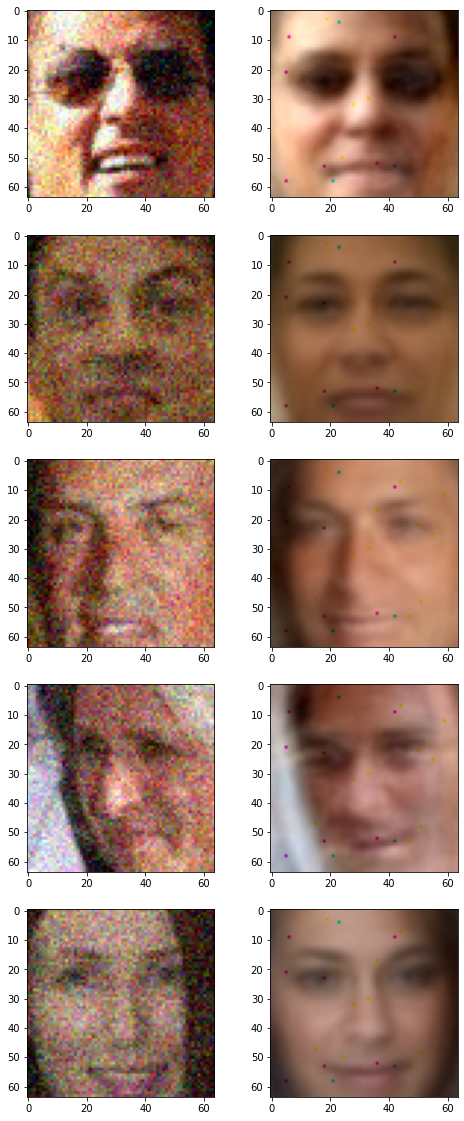

In [ ]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(np.clip(gt, 0, 1))
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(np.clip(res, 0, 1))

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
# VAE для картинок

features = 64

class VAE0(nn.Module):
    def __init__(self):
      super(VAE0, self).__init__()

      self.flatten = nn.Flatten()
      
      self.encoder = nn.Sequential(
        nn.Linear(in_features=12288, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=features*2)
  )
      
      self.decoder = nn.Sequential(
        nn.Linear(in_features=features, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=12288)
  )

    def encode(self, x):

      x = self.flatten(x).float()
      x = self.encoder(x).view(-1, 2, features)
      
      mu = x[:, 0, :]
      logsigma = x[:, 1, :]

      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
      if self.training:
          std = torch.exp(0.5 * logsigma)
          eps = torch.randn_like(std)
          sample = mu + (eps * std)
          return sample
      else:
          # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
          # на инференсе выход автоэнкодера должен быть детерминирован.
          return mu
    
    def decode(self, z):

      # reparameterize
      mu, log_var = self.encode(z)
      sample = self.gaussian_sampler(mu, log_var)

      # decode
      x = self.decoder(sample)
      reconstruction = torch.sigmoid(x)

      return reconstruction

    def forward(self, x):
      mu, logsigma = self.encode(x)
      reconstruction = self.decode(x)

      return mu, logsigma, reconstruction

    def sample(self, z):
      generated = self.decoder(z)
      generated = torch.sigmoid(generated)
      generated = generated.view(-1, 3, 64, 64)
      return generated

    def get_latent(self, x):
      x = self.flatten(x).float()
      
      x = self.encoder(x).view(-1, 2, features)
      mu = x[:, 0, :]
      log_var = x[:, 1, :]
      z = self.gaussian_sampler(mu, log_var)
      return z

Решил попробовать сверточную архитектуру:

In [ ]:
# VAE для картинок сверточная

features = 64

class VAE1(nn.Module):
    def __init__(self):
      super(VAE1, self).__init__()

      self.conv_encoder = nn.Sequential(
          nn.Conv2d(3, 16, (3, 3), padding=1, stride=2),
          nn.ReLU(),
          nn.Conv2d(16, 32, (3, 3), padding=1, stride=2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(8192, 12288)
      )
      
      self.encoder = nn.Sequential(
        nn.Linear(in_features=12288, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=features*2)
  )
      self.conv_decoder = nn.Sequential(
          nn.Unflatten(1, (1, 8, 8)),
          nn.ConvTranspose2d(1, 3, (3,3), 1, 2),
          nn.ReLU(),
          nn.ConvTranspose2d(3, 16, (3,3), 1, 2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(256, out_features=features)
      )
      
      self.decoder = nn.Sequential(
        nn.Linear(in_features=features, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=12288)
  )

    def encode(self, x):
      x = self.conv_encoder(x.permute(0,3,1,2).float())
      x = self.encoder(x).view(-1, 2, features)
      
      mu = x[:, 0, :]
      logsigma = x[:, 1, :]

      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
      if self.training:
          std = torch.exp(0.5 * logsigma)
          eps = torch.randn_like(std)
          sample = mu + (eps * std)
          return sample
      else:
          # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
          # на инференсе выход автоэнкодера должен быть детерминирован.
          return mu
    
    def decode(self, z):

      # reparameterize
      mu, log_var = self.encode(z)
      sample = self.gaussian_sampler(mu, log_var)

      # decode
      sample = self.conv_decoder(sample)
      x = self.decoder(sample)
      reconstruction = torch.sigmoid(x)

      return reconstruction

    def forward(self, x):
      mu, logsigma = self.encode(x)
      reconstruction = self.decode(x)

      return mu, logsigma, reconstruction

    def sample(self, z):
      z = self.conv_decoder(z)
      generated = self.decoder(z)
      generated = torch.sigmoid(generated)
      generated = generated.view(-1, 3, 64, 64)
      return generated

    def get_latent(self, x):
      x = self.conv_encoder(x.permute(0,3,1,2).float())
      x = self.encoder(x).view(-1, 2, features)
      mu = x[:, 0, :]
      log_var = x[:, 1, :]
      z = self.gaussian_sampler(mu, log_var)
      return z

In [ ]:
# VAE для картинок сверточная #2
features = 256

class VAE2(nn.Module):
    def __init__(self):
      super(VAE2, self).__init__()

      self.conv_encoder = nn.Sequential(
          nn.Conv2d(3, 16, (3, 3), stride=2),
          nn.ReLU(),
          nn.Conv2d(16, 32, (3, 3), stride=2),
          nn.ReLU(),
          nn.Conv2d(32, 96, (3, 3), stride=2),
          nn.Flatten(),
      )
      
      self.encoder = nn.Sequential(
        nn.Linear(in_features=4704, out_features=512), # CHANGE
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=features*2)
  )
      self.conv_decoder = nn.Sequential(
          nn.Unflatten(1, (1, 16, 16)),
          nn.ConvTranspose2d(1, 3, (3,3), 1),
          nn.ReLU(),
          nn.ConvTranspose2d(3, 16, (3,3), 1),
          nn.ReLU(),
          nn.ConvTranspose2d(16, 32, (3,3), 1),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 64, (3,3), 1),
          nn.Flatten(),
      )
      
      self.decoder = nn.Sequential(
        nn.Linear(in_features=36864, out_features=12288),
  )

    def encode(self, x):
      x = self.conv_encoder(x.permute(0,3,1,2).float())
      x = self.encoder(x).view(-1, 2, features)
      
      mu = x[:, 0, :]
      logsigma = x[:, 1, :]

      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
      if self.training:
          std = torch.exp(0.5 * logsigma)
          eps = torch.randn_like(std)
          sample = mu + (eps * std)
          return sample
      else:
          # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
          # на инференсе выход автоэнкодера должен быть детерминирован.
          return mu
    
    def decode(self, z):

      # reparameterize
      mu, log_var = self.encode(z)
      sample = self.gaussian_sampler(mu, log_var)

      # decode
      sample = self.conv_decoder(sample)
      x = self.decoder(sample)
      reconstruction = torch.sigmoid(x)

      return reconstruction

    def forward(self, x):
      mu, logsigma = self.encode(x)
      reconstruction = self.decode(x)

      return mu, logsigma, reconstruction

    def sample(self, z):
      z = self.conv_decoder(z)
      generated = self.decoder(z)
      generated = torch.sigmoid(generated)
      generated = generated.view(-1, 3, 64, 64)
      return generated

    def get_latent(self, x):
      x = self.conv_encoder(x.permute(0,3,1,2).float())
      x = self.encoder(x).view(-1, 2, features)
      mu = x[:, 0, :]
      log_var = x[:, 1, :]
      z = self.gaussian_sampler(mu, log_var)
      return z

In [ ]:
# Обучим VAE на картинках
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = loss_vae
vae = VAE2().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)

n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    vae.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        batch = batch
        optimizer.zero_grad()
        mu, logsigma, reconstruction = vae(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    vae.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          batch = batch
          mu, logsigma, reconstruction  = vae(batch.to(device))
          reconstruction = reconstruction.view(-1, 64, 64, 3)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

In [ ]:
vae.eval()
with torch.no_grad():
    for batch in val_loader:
      batch = batch
      mu, logsigma, reconstruction = vae(batch.to(device))
      reconstruction = reconstruction.view(-1, 64, 64, 3)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.numpy()
      break

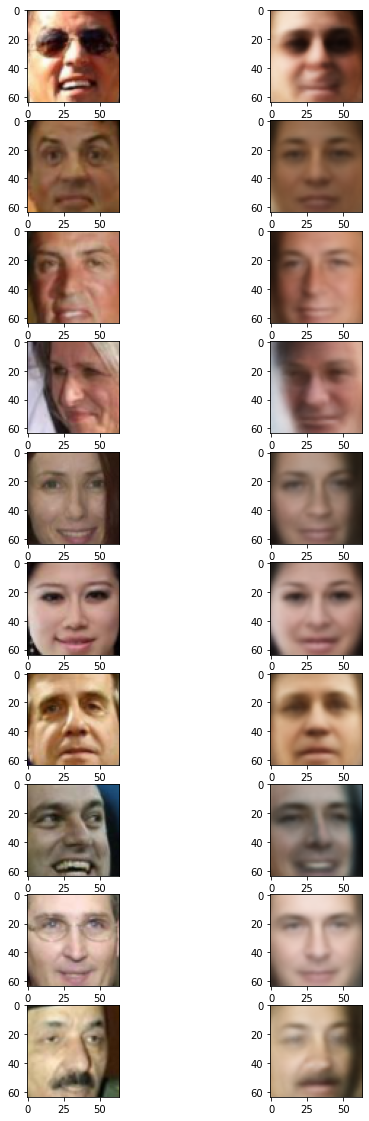

In [ ]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:10], result[:10])):
  plt.subplot(10, 2, 2*i+1)
  plt.imshow(np.squeeze(gt))
  plt.subplot(10, 2, 2*i+2)
  plt.imshow(np.squeeze(res))

In [ ]:
# codes = <поучите латентные представления картинок из трейна>
latent = None
vae.eval()
with torch.no_grad():
    for batch in val_loader:
      if (latent == None):
        latent = vae.get_latent(batch.to(device))
      else:
        latent = torch.cat((latent, vae.get_latent(batch.to(device))), 0)

In [ ]:
from scipy import spatial # Вместо LSHForest
tree = spatial.KDTree(latent.cpu().detach())

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  # code = <получение латентного представления image>
  latent1 = vae.get_latent(torch.FloatTensor(image[None, :]).to(device))
    
  distances, idx = tree.query(latent1.cpu().detach(), k=n_neighbors)

  return distances, X_test[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    neighbors = np.squeeze(neighbors)
    distances = distances[0]
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

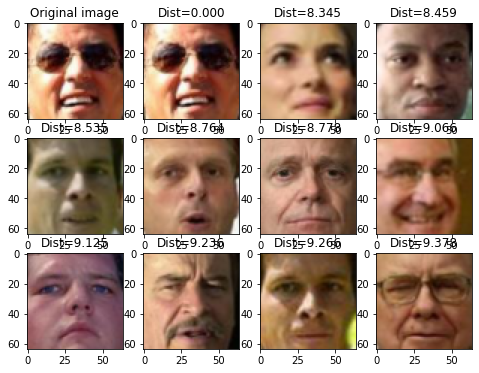

In [ ]:
show_similar(X_test[0])